In [1]:
# !pip install torch_geometric
# !pip install shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch_geometric
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Linear, LayerNorm, ReLU, Dropout
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv, MessagePassing
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.transforms as T


from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
import sklearn.metrics as metrics
import scipy.sparse as sp

import warnings
warnings.filterwarnings("ignore")
import math
import shap

/home/coean/miniconda3/envs/gnn_shap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.__version__)

1.12.1


In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


cuda:0


In [5]:
# datasets_folder = '/content/drive/MyDrive/Colab Notebooks/ssn/projekt/datasets/elliptic_augmented_dataset/'
datasets_folder = '../datasets/elliptic_augmented_dataset/'

In [6]:
def split_edges_into_train_and_test(edges_dataframe, node_features_with_class):
    edges_amount = len(edges_dataframe)
    step = int(edges_amount * 0.02)    

    train_edges = [] # edges which have both nodes labeled.
    test_edges = []  # edges which have both nodes unlabeled.
    
    # this may take a long time
    for i, edge in enumerate(np.array(edges_dataframe)):
        if i % step == 0:
            print(f'{ round(i/ edges_amount * 100)}%')
            
        found_start_node = node_features_with_class[node_features_with_class[0] == edge[0]]
        
        #ignore edges for which a node does not exist (this happened once)
        if len(found_start_node) == 0: continue
            
        found_end_node = node_features_with_class[node_features_with_class[0] == edge[1]]
        if len(found_end_node) == 0: continue
            
        if found_start_node.values[0, -1] != 2 and found_end_node.values[0, -1] != 2:
            train_edges.append(edge)
            continue
        
        if found_start_node.values[0, -1] == 2 and found_end_node.values[0, -1] == 2:
            test_edges.append(edge)
            continue
          
        # if found_start_node.values[0, -1] == 2:
        #   test_edges.append(edge)
        #   continue
        
        # if found_end_node.values[0, -1] == 2:
        #   test_edges.append(edge)
        # else:
        #   train_edges.append(edge)
          
    train_edges = pd.DataFrame(train_edges)
    test_edges = pd.DataFrame(test_edges)
    return train_edges, test_edges

In [7]:
# This will read from cached files if they exist. If you change the code, delete the cached files.
def split_edges_into_train_and_test_IO(datasets_folder):
    train_edges_filepath = datasets_folder + 'train_edges.csv'
    test_edges_filepath = datasets_folder + 'test_edges.csv'
    
    train_edges = [] # edges which have both nodes labeled.
    test_edges = [] # edges which one or both nodes are unlabeled.
    if os.path.isfile(train_edges_filepath) and os.path.isfile(test_edges_filepath):
        train_edges = pd.read_csv(train_edges_filepath, sep=',').drop(columns=['Unnamed: 0']).rename(columns = {'0': 0, '1':1})
        test_edges = pd.read_csv(test_edges_filepath, sep=',').drop(columns=['Unnamed: 0']).rename(columns = {'0': 0, '1':1})
        
    else:
        edges_filepath = datasets_folder + 'elliptic_txs_edgelist.csv'
        edges_dataframe = pd.read_csv(edges_filepath, sep=',')
        train_edges, test_edges = split_edges_into_train_and_test(edges_dataframe, node_features_dataframe_with_class_without_timestep)
        
        # save the train_edges and test_edges to file so that the expensive split does not have to run every time.
        train_edges.to_csv(train_edges_filepath)
        test_edges.to_csv(test_edges_filepath)
    
    return train_edges, test_edges

In [8]:
classes_filepath = datasets_folder + 'elliptic_txs_classes.csv'
classes_dataframe = pd.read_csv(classes_filepath, sep=',')
classes_dataframe

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown
...,...,...
276700,-80255194,unknown
276701,-229310245,suspicious
276702,-223754303,unknown
276703,-625924180,suspicious


In [9]:
# initially 2 is licit, 1 is illicit, suspicious is also illicit, unknown is unknown
# after remapping 0 is illicit, 1 is licit, 2 is unknown
# rows with class 0 and 1 will be used for training
# rows with class 2 will be used for prediction

def remap_label(label):
  if label == '1': return 0
  if label == 'suspicious': return 0
  if label == '2': return 1
  return 2

In [10]:
classes_dataframe_after_remap = classes_dataframe.copy()
classes_dataframe_after_remap['class'] = classes_dataframe['class'].map(remap_label)
classes_dataframe_after_remap


,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,1
4,230460314,2
...,...,...
276700,-80255194,2
276701,-229310245,0
276702,-223754303,2
276703,-625924180,0


In [11]:
print('illicit: ' + str(len(classes_dataframe_after_remap[classes_dataframe_after_remap['class'] == 0] )))
print('licit: ' + str(len(classes_dataframe_after_remap[classes_dataframe_after_remap['class'] == 1])))
print('unknown: ' + str(len(classes_dataframe_after_remap[classes_dataframe_after_remap['class'] == 2])))


illicit: 29477
licit: 42019
unknown: 205209


In [12]:
node_features_filepath = datasets_folder + 'elliptic_txs_features.csv'
node_features_dataframe = pd.read_csv(node_features_filepath, sep=',', header=None)
# node_features_dataframe
node_features_dataframe_with_class = node_features_dataframe.copy()
node_features_dataframe_with_class['class'] = classes_dataframe_after_remap['class']
# node_features_dataframe_with_class
node_features_dataframe_with_class_without_timestep = node_features_dataframe_with_class.drop(columns=[1])
node_features_dataframe_with_class_without_timestep

,0,2,3,4,5,6,7,8,9,10,...,158,159,160,161,162,163,164,165,166,class
0,230425980,-0.056189,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133295,-0.088508,...,-0.582752,1.442895,1.440189,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,2
1,5530458,-0.056193,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133311,-0.088517,...,0.702410,-1.033609,-1.032884,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,2
2,232022460,-0.056378,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133972,-0.088883,...,0.467009,-1.033609,-1.032884,-0.106566,-0.113936,-0.135784,-0.186659,-0.102834,-0.102128,2
3,232438397,0.043005,0.743641,-0.644127,2.874647,-0.068726,2.304311,3.142835,-0.134902,-0.058112,...,-0.595477,0.204643,0.203652,0.994235,0.099367,-0.135784,0.669253,-0.102834,-0.102128,1
4,230460314,0.294595,-0.131268,-1.185821,0.125213,0.375512,0.188604,-0.101009,-0.134776,0.033618,...,-0.380435,0.484856,0.546219,0.003514,0.312670,0.369103,1.281230,0.201809,0.202687,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276700,-80255194,-0.015471,0.043889,1.522650,-0.058083,-0.046514,-0.020871,-0.101009,-0.134902,-0.015154,...,-0.302816,1.442895,1.440189,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,2
276701,-229310245,-0.056634,-0.141863,0.980956,-0.149731,-0.068726,-0.125609,-0.101009,-0.134903,-0.089391,...,-0.570028,0.204643,0.203652,-0.106566,-0.113936,-0.135784,-0.186659,-0.102834,-0.102128,0
276702,-223754303,-0.056336,-0.119014,0.980956,-0.149731,-0.068726,-0.125609,-0.101009,-0.134890,-0.088828,...,-0.595477,0.204643,0.203652,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,2
276703,-625924180,-0.052898,-0.109119,-1.185821,-0.131401,-0.068726,-0.167505,0.136346,-0.134233,-0.085575,...,0.447922,0.204643,0.203652,-0.106566,-0.113936,-0.135784,-0.186659,-0.102834,-0.102128,0


In [13]:
train_edges, test_edges = split_edges_into_train_and_test_IO(datasets_folder)
print(len(train_edges))
print(len(test_edges))
train_edges

36633
131778


,0,1
0,232344069,27553029
1,3881097,232457116
2,232051089,232470704
3,230473487,7089694
4,231182296,14660781
...,...,...
36628,-335492958,336712245
36629,-16565051,21440143
36630,-335493020,336712245
36631,-335493021,336712245


In [14]:
# Splitting nodes into train and test
train_node_features = node_features_dataframe_with_class_without_timestep[node_features_dataframe_with_class_without_timestep['class'] != 2]
test_node_features = node_features_dataframe_with_class_without_timestep[node_features_dataframe_with_class_without_timestep['class'] == 2]
# train_node_features
train_node_features_without_class = train_node_features.drop(columns=['class'])
test_node_features_without_class = test_node_features.drop(columns=['class'])

In [15]:
def create_reindex_dict(node_features_without_class): 
    reindex_dictionary = dict()
    for i, node_id in enumerate(node_features_without_class[0]):
      reindex_dictionary[node_id] = i
    return reindex_dictionary

In [16]:
# # now we need to reindex the train nodes and train edges so that node id is equal to row id
def reindex_edges(node_features_without_class, edges):
    reindex_dictionary = create_reindex_dict(node_features_without_class)
    edges_reindexed = edges.copy()
    edges_reindexed[0] = edges[0].map(lambda node_id: reindex_dictionary[node_id])
    edges_reindexed[1] = edges[1].map(lambda node_id: reindex_dictionary[node_id])
    return edges_reindexed


In [17]:
train_edges_reindexed = reindex_edges(train_node_features_without_class, train_edges)


In [19]:
test_edges_reindexed = reindex_edges(test_node_features_without_class, test_edges)
# now we have test nodes & test edges which can be used to test the trained model

In [20]:
def create_train_data_object(train_edges_reindexed, train_node_features_without_class, train_classes):
    edge_index = torch.tensor(np.array(train_edges_reindexed), dtype=torch.long)
    x = torch.tensor(np.array(train_node_features_without_class), dtype=torch.float)
    y = torch.tensor(np.array(train_classes), dtype=torch.float)
    data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)
    data.validate(raise_on_error = True)
    split = T.RandomNodeSplit(num_val=0.1, num_test=0)
    data_with_masks = split(data)
    return data_with_masks

In [21]:
def create_test_data_object(test_edges_reindexed, test_node_features_without_class):
    edge_index = torch.tensor(np.array(test_edges_reindexed), dtype=torch.long)
    x = torch.tensor(np.array(test_node_features_without_class), dtype=torch.float)
    data = Data(x=x, edge_index=edge_index.t().contiguous())
    data.validate(raise_on_error = True)
    return data

In [22]:
data_with_masks = create_train_data_object(train_edges_reindexed, train_node_features_without_class, train_node_features['class'])
data_with_masks

Data(x=[71496, 166], edge_index=[2, 36633], y=[71496], train_mask=[71496], val_mask=[71496], test_mask=[71496])

In [23]:
test_data_object = create_test_data_object(test_edges_reindexed, test_node_features_without_class)
test_data_object

Data(x=[205209, 166], edge_index=[2, 131778])

In [24]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        self.conv1 = GATConv(data_with_masks.num_features, self.hid, heads = self.in_head)
        self.conv2 = GATConv(self.hid * self.in_head, 1, concat=False, heads = self.out_head)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training = self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training = self.training)
        x = self.conv2(x, edge_index)
        return F.sigmoid(x)

In [25]:
model = Net().to(device)
data_in_device = data_with_masks.to(device)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

In [27]:
train_auc_values = list()
val_auc_values = list()
loss_values = list()
train_mse_values = list()
val_mse_values = list()

epochs_amount = 150

model.train()
for epoch in range(epochs_amount):
    optimizer.zero_grad()
    # out = model(data_in_device.x, data_in_device.edge_index)
    out = model(data_in_device)
    out = out.reshape((data_in_device.x.shape[0]))
    loss = criterion(out[data_in_device.train_mask], data_in_device.y[data_in_device.train_mask])
    
    with torch.no_grad():
        loss_values.append(loss.item())
    
        train_auc = roc_auc_score(data_in_device.y[data_in_device.train_mask].cpu().numpy(), out[data_in_device.train_mask].cpu().numpy()) 
        train_auc_values.append(train_auc)
        
        val_auc = roc_auc_score(data_in_device.y[data_in_device.val_mask].detach().cpu().numpy(), out[data_in_device.val_mask].detach().cpu().numpy())
        val_auc_values.append(val_auc)
        
        train_mean_squared_error_value = metrics.mean_squared_error(data_in_device.y[data_in_device.train_mask].detach().cpu().numpy(), out[data_in_device.train_mask].detach().cpu().numpy())
        train_mse_values.append(train_mean_squared_error_value)
        
        val_mean_squared_error_value = metrics.mean_squared_error(data_in_device.y[data_in_device.val_mask].detach().cpu().numpy(), out[data_in_device.val_mask].detach().cpu().numpy())
        val_mse_values.append(val_mean_squared_error_value)
    
        if epoch%5 == 0:
            print("epoch: {} - loss: {} - train_roc: {} - val_auc: {} - train_mse: {} - val_mse - {}".format(epoch, loss.item(), train_auc, val_auc, train_mean_squared_error_value, val_mean_squared_error_value))
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)

model.eval()

epoch: 0 - loss: 18.158447265625 - train_roc: 0.6056350145236995 - val_auc: 0.6104299283366112 - train_mse: 0.32462790608406067 - val_mse - 0.31897303462028503
epoch: 5 - loss: 18.35112953186035 - train_roc: 0.6500756723483325 - val_auc: 0.656243866105284 - train_mse: 0.27164143323898315 - val_mse - 0.26500648260116577
epoch: 10 - loss: 17.538257598876953 - train_roc: 0.6653208220524767 - val_auc: 0.663548156679332 - train_mse: 0.2554122507572174 - val_mse - 0.2530975043773651
epoch: 15 - loss: 10.637168884277344 - train_roc: 0.7829379447517474 - val_auc: 0.7735316918435287 - train_mse: 0.18378448486328125 - val_mse - 0.18615685403347015
epoch: 20 - loss: 5.010118007659912 - train_roc: 0.884152035157456 - val_auc: 0.8805028347530389 - train_mse: 0.12553651630878448 - val_mse - 0.12714853882789612
epoch: 25 - loss: 4.499019622802734 - train_roc: 0.8949208280880121 - val_auc: 0.893724383880742 - train_mse: 0.1178918406367302 - val_mse - 0.11851329356431961
epoch: 30 - loss: 4.39210462570

Net(
  (conv1): GATConv(166, 8, heads=8)
  (conv2): GATConv(64, 1, heads=1)
)

In [28]:
model_name = 'gnn_augmented_model'
torch.save(model.state_dict(), model_name)

In [29]:
# model.load_state_dict(torch.load(model_name))

In [30]:
def show_loss(loss_values):
    plt.plot(range(epochs_amount), loss_values, label='loss')
    plt.title('loss based on BCELoss criterion')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

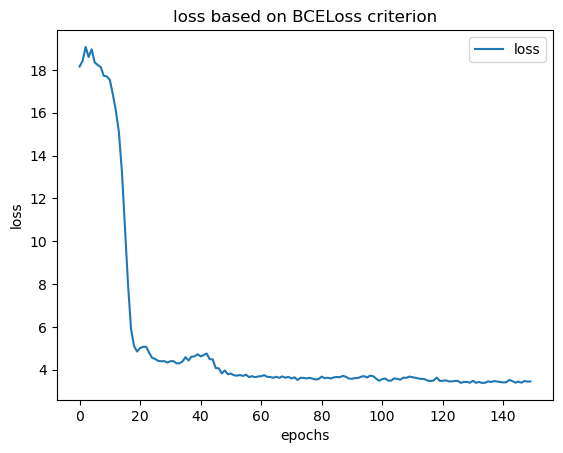

In [31]:
show_loss(loss_values)

In [32]:
def show_mse(train_mse_values, val_mse_values):
    plt.plot(range(epochs_amount), train_mse_values, label= "train")
    plt.plot(range(epochs_amount), val_mse_values, label= "val")
    plt.xlabel("epochs")
    plt.ylabel("mean square error")
    plt.title("mean square error change as epochs progress")
    plt.legend()
    plt.show()

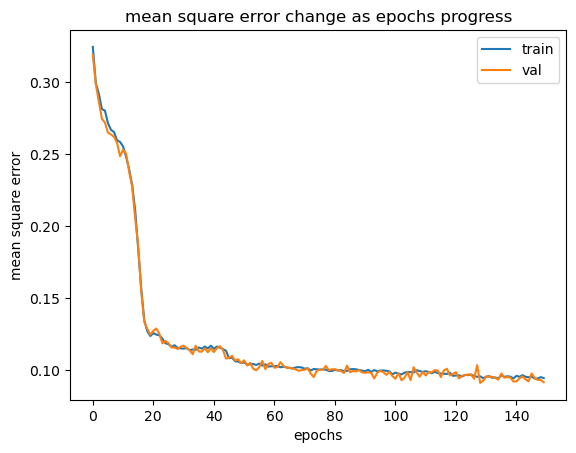

In [33]:
show_mse(train_mse_values, val_mse_values)

In [34]:
def show_auc_roc(train_auc_values, val_auc_values):
    plt.plot(range(epochs_amount), train_auc_values, label= "train")
    plt.plot(range(epochs_amount), val_auc_values, label= "val")
    plt.xlabel("epochs")
    plt.ylabel("roc_auc_score")
    plt.title("AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) change as epochs progress")
    plt.legend()
    plt.show()

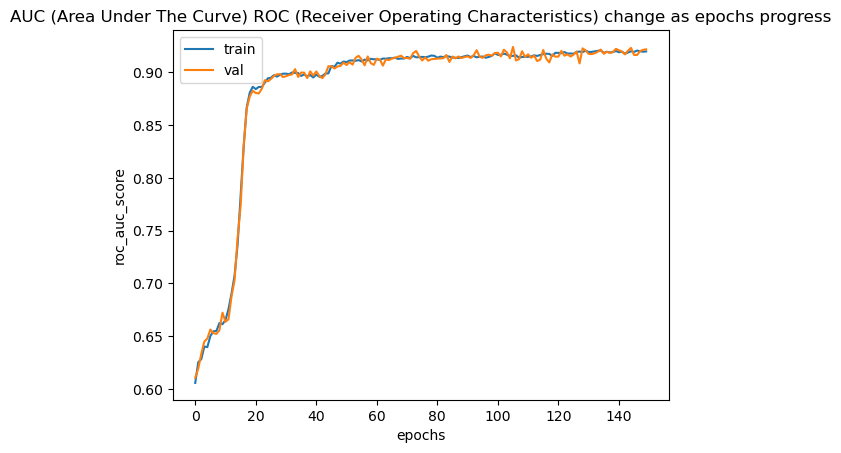

In [35]:
show_auc_roc(train_auc_values, val_auc_values)

In [38]:
val_output = model(data_in_device)

In [41]:
def show_roc_curve(data_in_device, val_output):
    fpr, tpr, thresholds = roc_curve(data_in_device.y[data_in_device.val_mask].detach().cpu().numpy(), val_output[data_in_device.val_mask].detach().cpu().numpy(), pos_label=1)
    print(fpr)
    print(tpr)
    print(thresholds)
    roc_auc = metrics.auc(fpr, tpr)
    roc_curve_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_curve_display.plot()
    plt.title("ROC curve")
    plt.show()

[0.         0.15685596 1.        ]
[0. 1. 1.]
[2. 1. 0.]


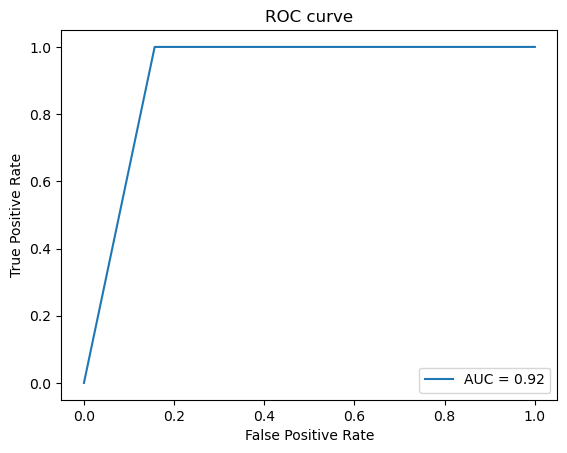

In [42]:
show_roc_curve(data_in_device, val_output)

In [43]:
mean_squared_error_value = metrics.mean_squared_error(data_in_device.y[data_in_device.val_mask].detach().cpu().numpy(), val_output[data_in_device.val_mask].detach().cpu().numpy())
mean_squared_error_value

0.063356645

In [44]:
def show_confusion_matrix(data_in_device, val_output, normalize=None):
    
    val_confusion_matrix = confusion_matrix(data_in_device.y[data_in_device.val_mask].detach().cpu().numpy(), val_output[data_in_device.val_mask].detach().cpu().numpy(), normalize=normalize)
    confusion_matrix_display = ConfusionMatrixDisplay(val_confusion_matrix)
    confusion_matrix_display.plot()
    if normalize == None:
        plt.title("0 is illicit, 1 is licit")
    else:
        plt.title("0 is illicit, 1 is licit but in %")
    plt.show()


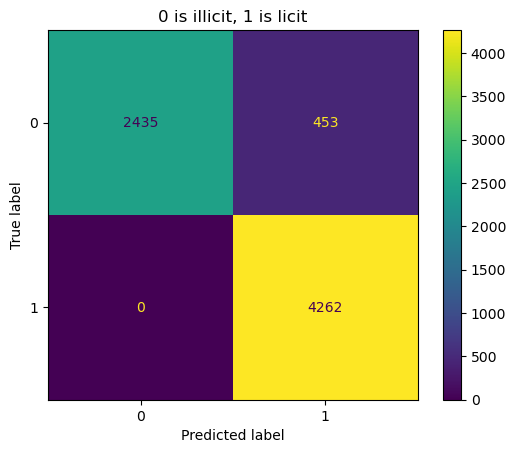

In [45]:
show_confusion_matrix(data_in_device, val_output)

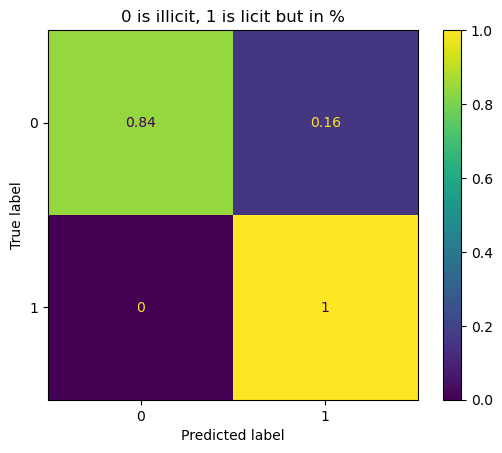

In [46]:
show_confusion_matrix(data_in_device, val_output, 'true')

In [47]:
# Mean Square Error

In [48]:
# now testing the model on unlabeled dataset to see if proportions between predicted classes are as expected.

In [49]:
test_data_in_device = test_data_object.to(device)
test_output = model(test_data_in_device)
test_output


tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<SigmoidBackward0>)

amount_of_illicit_predicted_transactions=48004
amount_of_licit_predicted_transactions=157205
percent of predicted illicit transactions: 0.23%
percent of predicted licit transactions: 0.77%


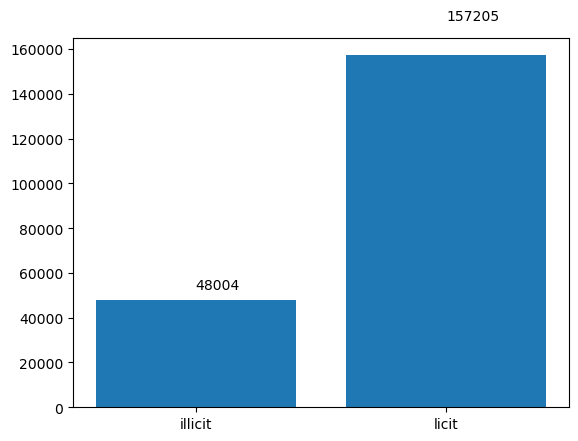

In [50]:
amount_of_all_test_samples = test_output.shape[0]
amount_of_licit_predicted_transactions = test_output.count_nonzero().item()
amount_of_illicit_predicted_transactions = amount_of_all_test_samples - amount_of_licit_predicted_transactions

print(f'{amount_of_illicit_predicted_transactions=}')
print(f'{amount_of_licit_predicted_transactions=}')


print(f'percent of predicted illicit transactions: {round(amount_of_illicit_predicted_transactions/amount_of_all_test_samples, 2)}%')
print(f'percent of predicted licit transactions: {round(amount_of_licit_predicted_transactions/amount_of_all_test_samples, 2)}%')
x = ['illicit', 'licit']
y = [amount_of_illicit_predicted_transactions, amount_of_licit_predicted_transactions]
plt.bar(x, y)
# plt.text(x=0, y= 0,s= 0)
plt.text(x='illicit', y= amount_of_illicit_predicted_transactions * 1.1,s= amount_of_illicit_predicted_transactions)
plt.text(x='licit', y= amount_of_licit_predicted_transactions * 1.1,s= amount_of_licit_predicted_transactions)
plt.show()


In [51]:
test_data_in_device.x.shape

torch.Size([205209, 166])

In [52]:
test_data_in_device.x[0].shape

torch.Size([166])

In [53]:
# # explainer = shap.GradientExplainer(model, test_data_in_device.x)
# # shap_values = explainer(test_data_in_device.x)

# explainer = shap.Explainer(model, test_data_in_device.x.reshape(test_data_in_device.x.shape[0], test_data_in_device.x.shape[1], 1))
# shap_values = explainer(test_data_in_device.x.reshape(test_data_in_device.x.shape[0], test_data_in_device.x.shape[1], 1))

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations